The idea is to do the clustering with SigMA, then perform the kneed routine on two variables of choice. Everything above the kneed threshold retains its label, everything below gets the label -1. Then, I will do a nmi for the new labels.

### Modules

In [1]:
from astropy.stats import knuth_bin_width, freedman_bin_width
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import normalized_mutual_info_score as nmi
from kneed import KneeLocator

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"



from SigMA.SigMA import SigMA
from DistantSigMA.Analysis.IsochroneArchive.myTools import my_utility


### Data

In [2]:
# ---------------------------------------------------------
# Load data
mock_df = pd.read_csv("/Users/alena/PycharmProjects/Distant_SigMA/Data/Mock/Box_0_with_all_clustering_results.csv")


data = mock_df.loc[mock_df['parallax']>0]
data = data.loc[data['parallax']/data['parallax_error']>4.5].reset_index(drop=True)

data.shape

(57622, 33)

## 1. SigMA clustering with predetermined values

In [3]:
# ---------------------------------------------------------
# Clustering in XYZ and tangential velocity space
pm_axes = ['pmra', 'pmdec']
# v_tan_axes = ['v_a_lsr', 'v_d_lsr']  # tangential velocity in LSR

# Clustering in XYZ and UVW space
xyz_axes = ['ra', 'dec', 'parallax']
# uvw_axes = ['U', 'V', 'W']


cluster_features = xyz_axes + pm_axes
scale_factors = {'vel': {'features': ['parallax'], 'factor': 0.2}}

sigma_kwargs = dict(
    cluster_features=cluster_features,
    scale_factors=scale_factors,
    # These are the default values and should be kept for now
    nb_resampling=0, max_knn_density=101,
    beta=0.99, knn_initcluster_graph=45,
    do_remove_edges=True
)

In [4]:
%%time
clusterer = SigMA(data=data, **sigma_kwargs).fit(alpha=0.05, knn=15, bh_correction=True)

Performing gradient ascend using a 15-NN density estimation.
Updated significance threshold: 1.00e-05
CPU times: user 9.91 s, sys: 387 ms, total: 10.3 s
Wall time: 5.71 s


## 2. First comparison between true labels and SigMA clustering

In [5]:
nmi(data.labels, clusterer.labels_)

np.float64(0.9612101676584978)

In [6]:
labels_real = LabelEncoder().fit_transform(clusterer.labels_)  # Transform to 0 - (N-1)rho = clusterer.weights_
rho = clusterer.weights_

In [7]:
label_rho_df = pd.DataFrame(data=np.stack([labels_real, rho, data.labels.to_numpy()], axis=1), columns=["labels_SigMA", "density", "reference"])
label_rho_df.labels_SigMA = label_rho_df.labels_SigMA.astype(int)


big_df = pd.concat([data, label_rho_df], axis=1)

print(big_df.shape, label_rho_df.shape)

(57622, 36) (57622, 3)


In [8]:
big_df.to_csv("/Users/alena/PycharmProjects/Distant_SigMA/DistantSigMA/misc/noise_removal/noise_removal_input.csv")

## 3. Density vs Nstars

### 3.1. Design function

In [9]:
def kneed_procedure(df, density_multiplier: float = 0.15, kneed_dict: dict = {"method": "polynomial", "poly_deg": 3, "S": 1e3}):

    df_updated_labels = df.copy()
    for label in df_updated_labels.labels_SigMA.unique():
        # pick one cluster
        cluster = df_updated_labels[df_updated_labels.labels_SigMA == label]
        cluster_sorted = cluster.sort_values(by="density")
        sorted_densities = cluster_sorted.density.to_numpy()
        unique_densities, counts = np.unique(sorted_densities, return_counts=True)

        min_density = unique_densities[0] + unique_densities[0] * density_multiplier
        max_density = unique_densities[-1] - unique_densities[-1] * density_multiplier

        # Create a mask for densities within desired range
        mask = (unique_densities >= min_density) & (unique_densities <= max_density)

        # Filter arrays accordingly
        filtered_densities = unique_densities[mask]
        filtered_counts = counts[mask]
        filtered_cumulative_counts = np.cumsum(filtered_counts)

        kl = KneeLocator(x=filtered_densities, y = filtered_cumulative_counts, curve="convex", online=True, interp_method=kneed_dict["method"], polynomial_degree=kneed_dict["poly_deg"], S =kneed_dict["S"])

        min_elbow = min(kl.all_elbows)

        # Set label to -1 for all points in this cluster with density < min_elbow
        condition = (df_updated_labels.labels_SigMA == label) & (df_updated_labels.density < min_elbow)
        df_updated_labels.loc[condition, "labels_SigMA"] = -1

        return df_updated_labels



def kneed_plot(df, density_multiplier: float = 0.15, kneed_dict: dict = {"method": "polynomial", "poly_deg": 3, "S": 1e3}):


    f,ax = plt.subplots(5,6, figsize=(10,10))
    axes = ax.ravel()

    for label in df.labels_SigMA.unique():
        # pick one cluster
        cluster = df[df.labels_SigMA == label]
        cluster_sorted = cluster.sort_values(by="density")
        sorted_densities = cluster_sorted.density.to_numpy()
        unique_densities, counts = np.unique(sorted_densities, return_counts=True)
        cumulative_counts = np.cumsum(counts)

        min_density = unique_densities[0] + unique_densities[0] *density_multiplier
        max_density = unique_densities[-1] - unique_densities[-1] *density_multiplier

        # Create a mask for densities within desired range
        mask = (unique_densities >= min_density) & (unique_densities <= max_density)

        # Filter arrays accordingly
        filtered_densities = unique_densities[mask]
        filtered_counts = counts[mask]
        filtered_cumulative_counts = np.cumsum(filtered_counts)

        kl = KneeLocator(x=filtered_densities, y = filtered_cumulative_counts, curve="convex", online=True, interp_method=kneed_dict["method"], polynomial_degree=kneed_dict["poly_deg"], S =kneed_dict["S"])

        min_elbow = min(kl.all_elbows)

        star_counts = (sorted_densities >= min_elbow).sum()

        axes[label].step(unique_densities, cumulative_counts, where='post', label= f"C {label}")
        axes[label].vlines(x=min_elbow, ymin =0, ymax=max(cumulative_counts), color="red", ls="dashed")
        axes[label].legend(loc="upper left")


    return f

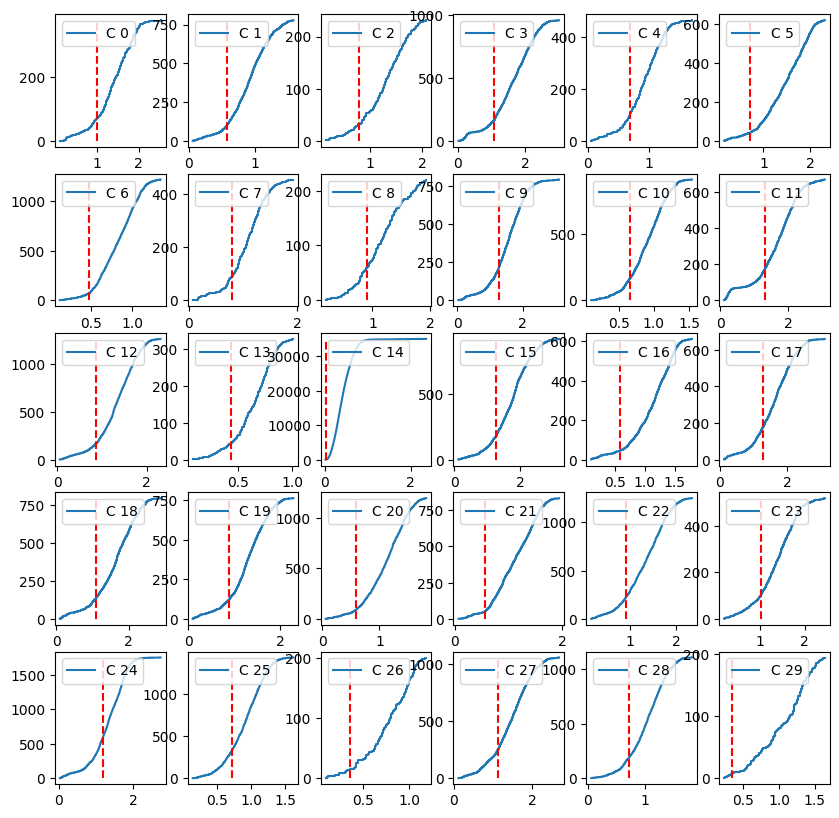

In [10]:
fig = kneed_plot(df = big_df)

plt.show()

In [11]:
df_updated = kneed_procedure(big_df)

nmi(df_updated.reference, df_updated.labels_SigMA)

np.float64(0.9605415874840696)

### 3.2. Binned

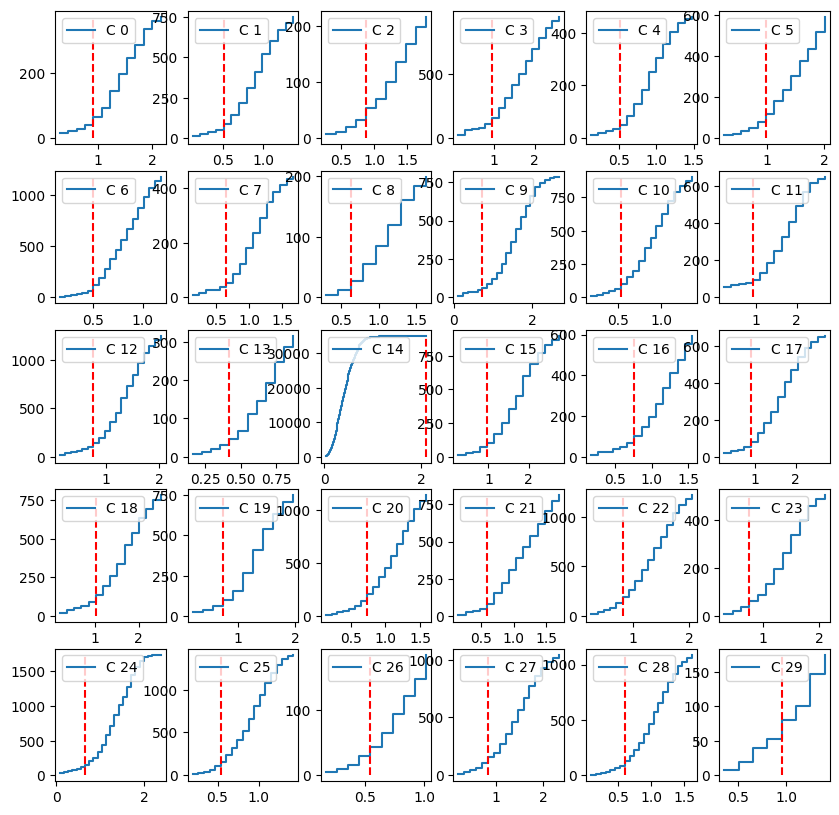

In [12]:
f,ax = plt.subplots(5,6, figsize=(10,10))
axes = ax.ravel()

nstar_elbows_binned, nstar_counts_binned = [], []

df_binned = big_df.copy()
for label in df_binned.labels_SigMA.unique():
    # pick one cluster
    cluster = df_binned[df_binned.labels_SigMA == label]
    cluster_sorted = cluster.sort_values(by="density")
    sorted_densities = cluster_sorted.density.to_numpy()
    min_density = sorted_densities[0] + sorted_densities[0] *0.1
    max_density = sorted_densities[-1] - sorted_densities[-1] *0.1

    # Create a mask for densities within desired range
    mask = (sorted_densities >= min_density) & (sorted_densities <= max_density)

    # Filter arrays accordingly
    filtered_densities = sorted_densities[mask]

    # Compute bin width and bin edges
    bin_width, bins = knuth_bin_width(filtered_densities, return_bins=True)
    # Compute histogram using the bins
    hist_counts, bin_edges = np.histogram(filtered_densities, bins=bins)
    # Compute cumulative counts
    cumulative_counts = np.cumsum(hist_counts)
    # For plotting (optional): get bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    kl = KneeLocator(x=bin_centers, y = cumulative_counts, curve="convex", online=True, interp_method="polynomial", polynomial_degree=3, S =1)
    min_elbow = min(kl.all_elbows)
    nstar_elbows_binned.append(min_elbow)

    star_counts = (sorted_densities >= min_elbow).sum()
    nstar_counts_binned.append(star_counts)

    axes[label].step(bin_centers, cumulative_counts, where='post', label= f"C {label}")
    axes[label].vlines(x=min_elbow, ymin =0, ymax=max(cumulative_counts), color="red", ls="dashed")
    axes[label].legend(loc="upper left")


    condition = (df_binned.labels_SigMA == label) & (df_binned.density < min_elbow)
    df_binned.loc[condition, "labels_SigMA"] = -1

plt.show()

In [13]:
nmi(df_binned.reference, df_binned.labels_SigMA)

np.float64(0.8787736630949826)

## 4. Velocity dispersion

In [14]:
def calc_velocity_dispersion(df):

    v_x = df.v_a_lsr.to_numpy()
    v_y = df.v_d_lsr.to_numpy()

    return np.var(v_x) + np.var(v_y)

### 4.1 No binning

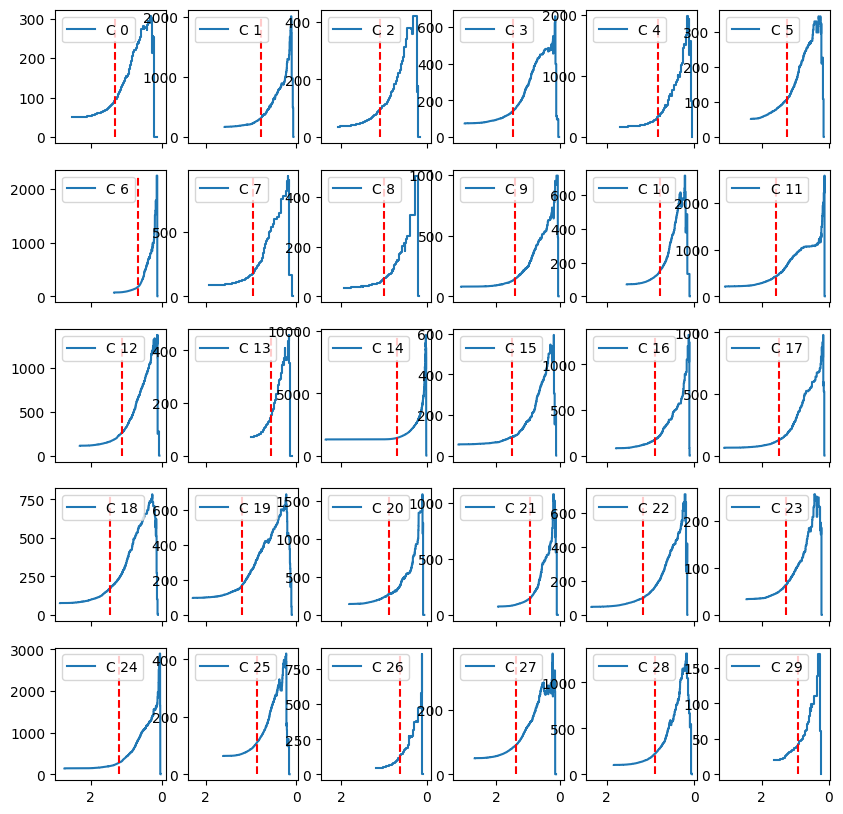

In [15]:
f,ax = plt.subplots(5,6, sharex="col", figsize=(10,10))
axes = ax.ravel()

v_disp_elbows_unbinned, v_disp_counts_unbinned = [], []

v_disp_df = big_df.copy()
for label in v_disp_df.labels_SigMA.unique()[:]:
    # pick one cluster
    cluster = v_disp_df[v_disp_df.labels_SigMA == label]
    cluster_sorted = cluster.sort_values(by="density")
    sorted_densities = cluster_sorted.density.to_numpy()
    unique_densities, counts = np.unique(sorted_densities, return_counts=True)
    cumulative_counts = np.cumsum(counts)

    min_density = unique_densities[0] + unique_densities[0] *0.
    max_density = unique_densities[-1] - unique_densities[-1] *0.

    # Create a mask for densities within desired range
    mask = (unique_densities >= min_density) & (unique_densities <= max_density)

    # Filter arrays accordingly
    filtered_densities = unique_densities[mask]
    filtered_counts = counts[mask]
    filtered_cumulative_counts = np.cumsum(filtered_counts)

    v_dispersions = []

    for rho_i in filtered_densities:
        subset = cluster_sorted[cluster_sorted.density <= rho_i]
        result_i = calc_velocity_dispersion(subset)  # Replace with your actual function
        v_dispersions.append(result_i)

    v_dispersions = np.array(v_dispersions)

    kl = KneeLocator(x=filtered_densities, y = v_dispersions, curve="convex", online=True, direction="decreasing", interp_method="polynomial",polynomial_degree=2, S =1)
    elbows = list(kl.all_elbows)
    max_elbow = max(elbows)
    v_disp_elbows_unbinned.append(max_elbow)
    star_counts = (sorted_densities >= max_elbow).sum()
    v_disp_counts_unbinned.append(star_counts)

    axes[label].step(filtered_densities, v_dispersions, where='post', label= f"C {label}")
    axes[label].vlines(x=max_elbow, ymin =0, ymax=max(v_dispersions), color="red", ls="dashed")
    axes[label].invert_xaxis()
    axes[label].legend(loc="upper left")


    condition = (v_disp_df.labels_SigMA == label) & (v_disp_df.density < min_elbow)
    v_disp_df.loc[condition, "labels_SigMA"] = -1

plt.show()

In [16]:
nmi(v_disp_df.reference, v_disp_df.labels_SigMA)


np.float64(0.8166117977611677)

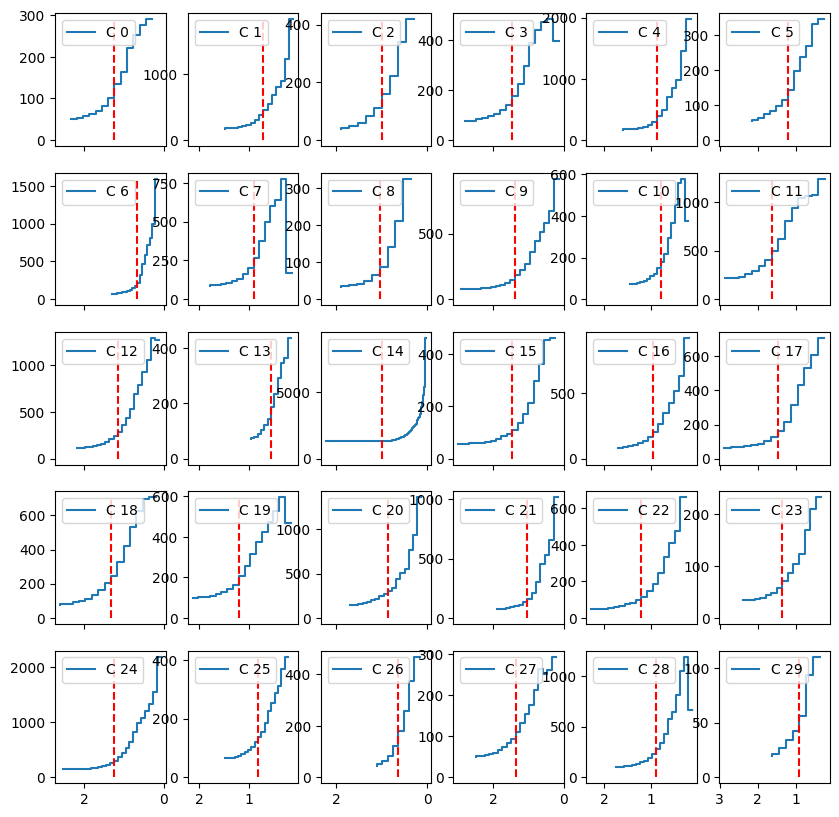

In [17]:
f,ax = plt.subplots(5,6, sharex="col", figsize=(10,10))
axes = ax.ravel()

v_disp_elbows_binned, v_disp_counts_binned = [], []

v_disp_binned_df = big_df.copy()
for label in v_disp_binned_df.labels_SigMA.unique()[:]:
    # pick one cluster
    cluster = v_disp_binned_df[v_disp_binned_df.labels_SigMA == label]
    cluster_sorted = cluster.sort_values(by="density")
    sorted_densities = cluster_sorted.density.to_numpy()
    unique_densities, counts = np.unique(sorted_densities, return_counts=True)

    min_density = unique_densities[0] + unique_densities[0] *0.15
    max_density = unique_densities[-1] - unique_densities[-1] *0.05

    # Create a mask for densities within desired range
    mask = (unique_densities >= min_density) & (unique_densities <= max_density)

    # Filter arrays accordingly
    filtered_densities = unique_densities[mask]

    # Compute bin width and bin edges
    bin_width, bins = freedman_bin_width(filtered_densities, return_bins=True)
    # Compute histogram using the bins
    hist_counts, bin_edges = np.histogram(filtered_densities, bins=bins)
    # Compute cumulative counts
    cumulative_counts = np.cumsum(hist_counts)
    # For plotting (optional): get bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    v_dispersions = []

    for rho_i in bin_centers:
        subset = cluster_sorted[cluster_sorted.density <= rho_i]
        result_i = calc_velocity_dispersion(subset)  # Replace with your actual function
        v_dispersions.append(result_i)

    v_dispersions = np.array(v_dispersions)

    kl = KneeLocator(x=bin_centers, y = v_dispersions, curve="convex", online=True, direction="decreasing",interp_method="polynomial",polynomial_degree=2, S =1)
    elbows = list(kl.all_elbows)
    max_elbow = max(elbows)
    v_disp_elbows_binned.append(max_elbow)

    star_counts = (sorted_densities >= max_elbow).sum()
    v_disp_counts_binned.append(star_counts)

    axes[label].step(bin_centers, v_dispersions, where='post', label= f"C {label}")
    axes[label].vlines(x=max_elbow, ymin =0, ymax=max(v_dispersions), color="red", ls="dashed")
    axes[label].invert_xaxis()
    axes[label].legend(loc="upper left")

    condition = (v_disp_binned_df.labels_SigMA == label) & (v_disp_binned_df.density < min_elbow)
    v_disp_binned_df.loc[condition, "labels_SigMA"] = -1

plt.show()

In [18]:
nmi(v_disp_binned_df.reference, v_disp_binned_df.labels_SigMA)


np.float64(0.8166117977611677)